In [129]:
import sys
import logging
import importlib
import itertools
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../../src/')
import utils  # noqa: E402

In [2]:
data_dir = Path('../../data')

In [3]:
importlib.reload(utils)
from utils import load_all_eliminateds_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout)
eliminateds = load_all_eliminateds_dict(data_dir)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

DEBUG:root:Loading eliminateds from ../../data/statistics/all-flat-none.jsonl
DEBUG:root:Loading eliminateds from ../../data/statistics/all-flat-cn.jsonl
DEBUG:root:Loading eliminateds from ../../data/statistics/all-flat-in.jsonl


In [4]:
importlib.reload(utils)
from utils import load_steps_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout)
steps = load_steps_dict(data_dir)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

DEBUG:root:Loading positive steps from ../../data/step/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading negative steps from ../../data/step/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading positive steps from ../../data/step/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading negative steps from ../../data/step/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading positive steps from ../../data/step/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading negative steps from ../../data/step/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading positive steps from ../../data/step/all-full-thompson-lockstep-none.jsonl
DEBUG:root:Loading negative steps from ../../data/step/all-full-thompson-lockstep-none.jsonl
DEBUG:root:Loading positive steps from ../../data/step/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading negative steps from ../../data/step/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading positive steps from ../../data/step/all-full-flat-spencer-cn.jsonl
DEBUG:ro

In [127]:
import importlib
importlib.reload(plt)
matching_type = 'full'
scheduler = 'spencer'
memo_scheme = 'none'
input_types = ['positive', 'negative']
xs = np.concatenate([
    steps[matching_type]['thompson'][scheduler][memo_scheme][input_type]
    for input_type in input_types
])
xlabel = "-".join([matching_type, 'thompson', scheduler, memo_scheme])
ys = np.concatenate([
    steps[matching_type]['flat'][scheduler][memo_scheme][input_type]
    for input_type in input_types
])
ylabel = "-".join([matching_type, 'flat', scheduler, memo_scheme])
zs = np.concatenate(
    [eliminateds[memo_scheme][input_type] for input_type in input_types])
threshold = 1
# Range excluding outliers
total = xs + ys
quartile_1 = np.quantile(total, 0.25)
quartile_3 = np.quantile(total, 0.75)
iqr = quartile_3 - quartile_1
maximum = np.max(total, where=xs <= quartile_3 + 1.5 * iqr, initial=-np.inf)
minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)

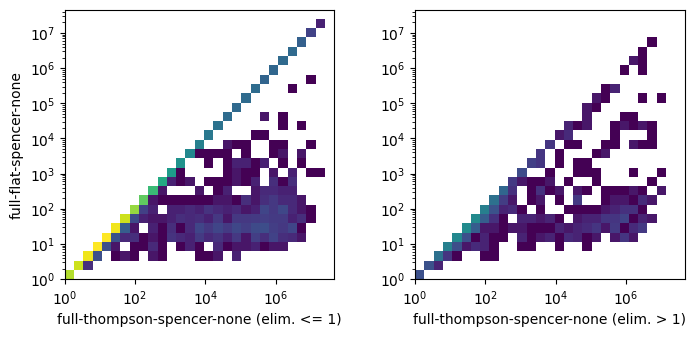

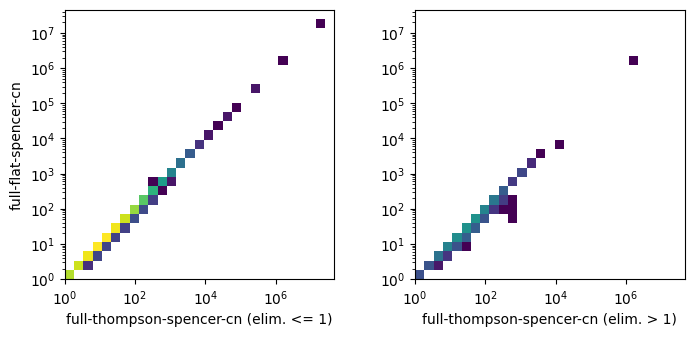

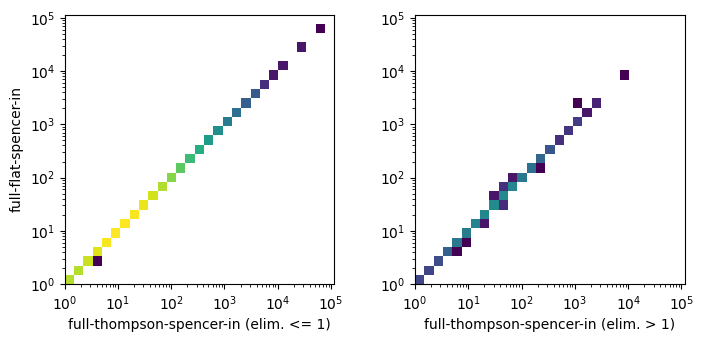

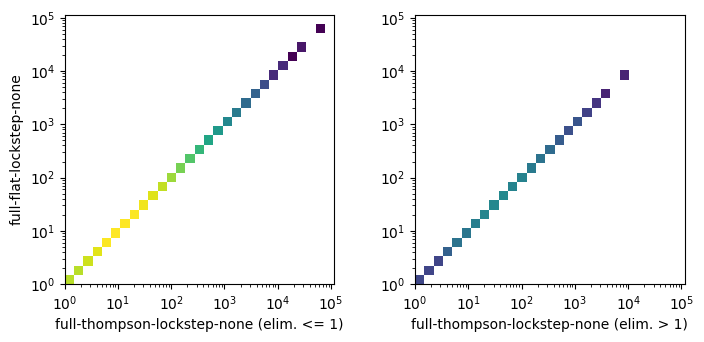

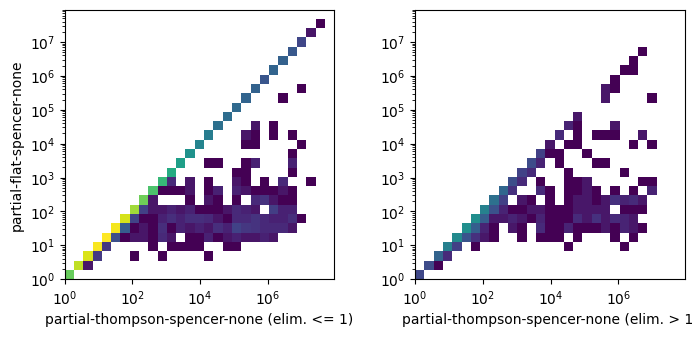

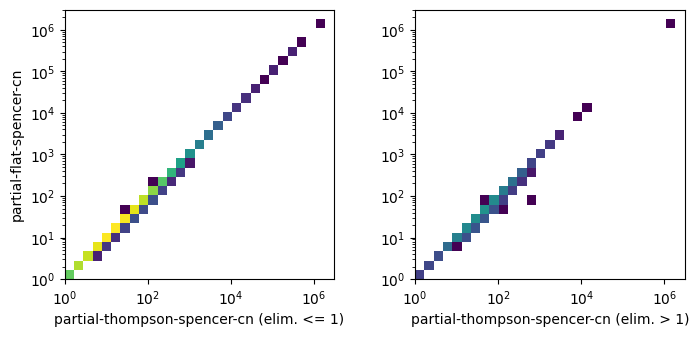

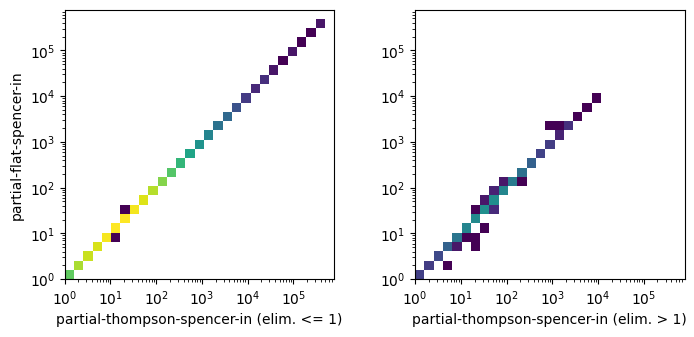

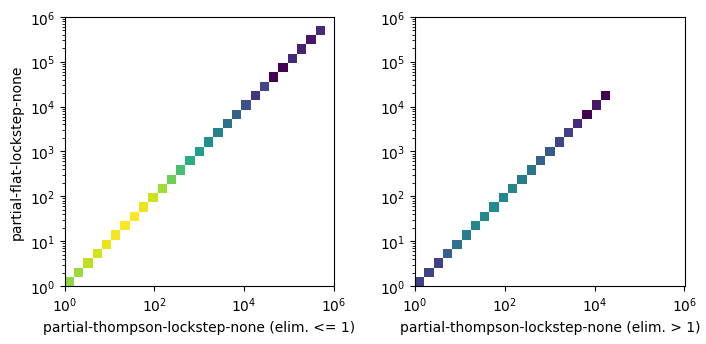

In [140]:
# Histogram 2D
import importlib
import itertools
importlib.reload(plt)

options = itertools.product(
    ['full', 'partial'],
    [('spencer', 'none'), ('spencer', 'cn'), ('spencer', 'in'), ('lockstep', 'none')]
)
threshold = 1

for matching_type, (scheduler, memo_scheme) in options:
    input_types = ['positive', 'negative']
    xs = np.concatenate([
        steps[matching_type]['thompson'][scheduler][memo_scheme][input_type]
        for input_type in input_types
    ])
    xlabel = "-".join([matching_type, 'thompson', scheduler, memo_scheme])
    ys = np.concatenate([
        steps[matching_type]['flat'][scheduler][memo_scheme][input_type]
        for input_type in input_types
    ])
    ylabel = "-".join([matching_type, 'flat', scheduler, memo_scheme])
    zs = np.concatenate(
        [eliminateds[memo_scheme][input_type] for input_type in input_types])
    # Range excluding outliers
    total = xs + ys
    quartile_1 = np.quantile(total, 0.25)
    quartile_3 = np.quantile(total, 0.75)
    iqr = quartile_3 - quartile_1
    maximum = np.max(total, where=xs <= quartile_3 + 1.5 * iqr, initial=-np.inf)
    minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)
    x_space = np.geomspace(1, max(xs+ys), 30)
    y_space = np.geomspace(1, max(ys+ys), 30)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    h, _, _, _ = axs[0].hist2d(xs[zs <= threshold], ys[zs <= threshold], bins=(x_space, y_space), vmin=1, norm='log')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(xlabel + f" (elim. <= {threshold})")
    axs[0].set_ylabel(ylabel)
    axs[0].axis('square')
    
    vmin = np.min(h)
    
    axs[1].hist2d(xs[zs > threshold], ys[zs > threshold], bins=(x_space, y_space), norm='log', vmin=1, vmax=vmax)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(xlabel + f" (elim. > {threshold})")
    axs[1].axis('square')
    
    plt.subplots_adjust(wspace=0.3)
    output_dir = Path('./outputs')
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = "-".join([matching_type, scheduler, memo_scheme]) + '.pdf'
    plt.savefig(output_dir / filename)
    plt.show()

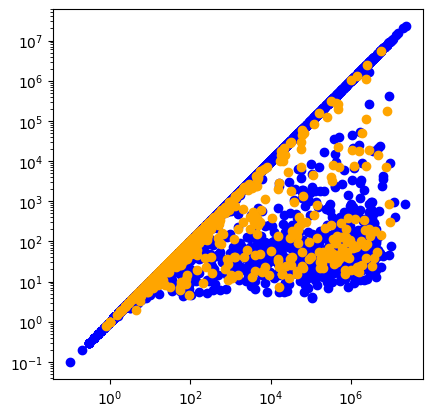

In [28]:
# Scatter plot
logging.basicConfig(level=logging.INFO, stream=sys.stderr, force=True)
plt.scatter(xs[zs < threshold], ys[zs < threshold], c='blue')
plt.scatter(xs[zs >= threshold], ys[zs >= threshold], c='orange')
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.show()

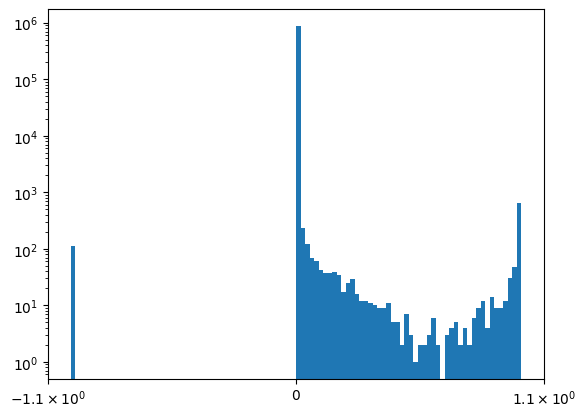

In [21]:
# Atan Histogram
normalized_theta = (np.arctan2(xs, ys) - np.pi/4) / (np.pi/4)
plt.hist(normalized_theta, bins=100, range=[-1, 1])
plt.xscale('symlog')
plt.yscale('log')
plt.show()

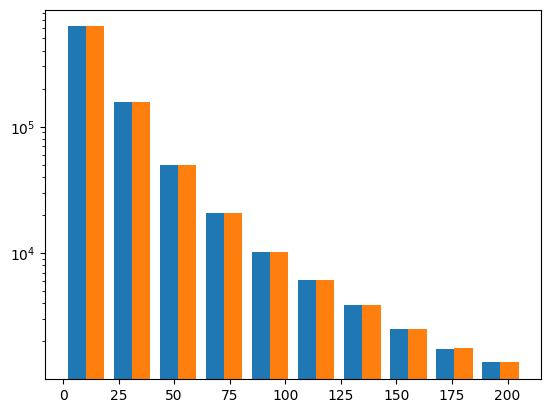

In [22]:
# Histogram (excluding outliers)
plt.hist([xs, ys], range=(minimum, maximum), log=True, bins=10)
plt.show()

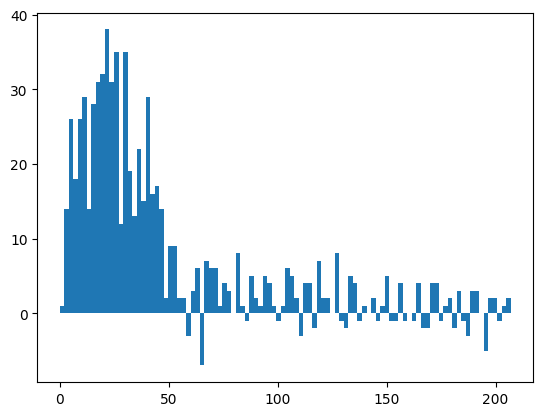

In [23]:
# Difference of histogram (excluding outliers)
plt1, bin1, _ = plt.hist(xs, range=(minimum, maximum), log=True, bins=100)
plt2, bin2, _ = plt.hist(ys, range=(minimum, maximum), log=True, bins=100)
plt.clf()
plt.bar(bin1[:-1], width=np.diff(bin1), height=plt2 - plt1, align='edge')
plt.show()